# 캐글에서 데이터 다운로드


원본 데이터 소스 : https://aihub.or.kr/aihubdata/data/view.do?dataSetSn=71579

train 데이터가 250GB정도 되기 때문에 val 데이터(30GB)를 우선 학습 데이터로 가져와서 train-val-test로 나눠서 사용예정

In [ ]:
# 필요한 라이브러리 설치(캐글)
!pip uninstall -y kaggle kagglesdk -q
!pip install --upgrade pip
!pip install kaggle -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import os

# kaggle.json 파일 업로드
if not os.path.exists("/content/kaggle.json"):
    print("kaggle.json 파일을 업로드해주세요:")
    uploaded = files.upload()
    print("업로드 완료!")
else:
    print("kaggle.json 파일이 이미 존재합니다.")

kaggle.json 파일을 업로드해주세요:


Saving kaggle.json to kaggle.json
업로드 완료!


In [ ]:
# Kaggle API 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API 설정 완료!")

Kaggle API 설정 완료!


In [ ]:
# 데이터 다운로드
!kaggle datasets download -d kimmookyeom/traffic-light-val -p /content/traffic_data --force
print("다운로드 완료!")

Dataset URL: https://www.kaggle.com/datasets/kimmookyeom/traffic-light-val
License(s): unknown
100% 33.1G/33.1G [14:18<00:00, 41.4MB/s]

다운로드 완료!


In [ ]:
# 다운로드된 데이터 압축풀기
%cd /content/traffic_data/
!unzip traffic-light-val.zip

Streaming output truncated to the last 5000 lines.
  inflating: 180.자율주행차의 다양한 주행환경에서의 신호등 신호정보 인지 영상 데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL/Clip_1312/Camera/Camera_Front/512_SD_1312_CF_022.json  
  inflating: 180.자율주행차의 다양한 주행환경에서의 신호등 신호정보 인지 영상 데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL/Clip_1312/Camera/Camera_Front/512_SD_1312_CF_027.json  
  inflating: 180.자율주행차의 다양한 주행환경에서의 신호등 신호정보 인지 영상 데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL/Clip_1312/Camera/Camera_Front/512_SD_1312_CF_034.json  
  inflating: 180.자율주행차의 다양한 주행환경에서의 신호등 신호정보 인지 영상 데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL/Clip_1312/Camera/Camera_Front/512_SD_1312_CF_041.json  
  inflating: 180.자율주행차의 다양한 주행환경에서의 신호등 신호정보 인지 영상 데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL/Clip_1313/Camera/Camera_Front/512_SD_1313_CF_

In [ ]:
%cd /content/traffic_data/
os.rename('180.자율주행차의 다양한 주행환경에서의 신호등 신호정보 인지 영상 데이터', '123')

/content/traffic_data


In [ ]:
# 모든 이미지를 images로 모으고 모든 라벨을 labels로 모으기
%mkdir /content/data/
%mkdir /content/data/images/
%mkdir /content/data/labels/
%mkdir /content/data/lidar/

# find 명령어로 파일을 찾아서 바로 이동(mv)
# -path: 특정 경로 패턴만 탐색
# -type f: 파일만 선택
# -exec mv ... {} +: 찾은 파일들을 한꺼번에 이동 (효율적)
!find /content/traffic_data/123/01-1.정식개방데이터/Validation/01.원천데이터/VS/ -path "*/Camera/Camera_Front/*" -type f -exec mv -t /content/data/images {} +
!find /content/traffic_data/123/01-1.정식개방데이터/Validation/02.라벨링데이터/VL/ -path "*/Camera/Camera_Front/*" -type f -exec mv -t /content/data/labels {} +
!find /content/traffic_data/123/01-1.정식개방데이터/Validation/01.원천데이터/VS/ -path "*/Lidar/Lidar_Roof/*" -type f -exec mv -t /content/data/lidar {} +


In [ ]:
# 전체 데이터 개수 확인
print(f'이미지 개수 : {len(os.listdir('/content/data/images'))}')
print(f'라벨 개수 : {len(os.listdir('/content/data/labels'))}')
print(f'라이다 개수 : {len(os.listdir('/content/data/lidar'))}')

이미지 개수 : 10000
라벨 개수 : 10000
라이다 개수 : 10000


In [ ]:
# 용량 확보 위해 사용하지 않는 데이터 삭제
%rm -rf /content/traffic_data/

# 데이터 전처리


In [ ]:
# 클래스 종류 파악하기
import json
import glob
import os
from collections import defaultdict, Counter

# 1. 파일 경로 설정
input_folder = '/content/data/labels/'
json_pattern = os.path.join(input_folder, '*.json')

# 2. 결과 저장을 위한 딕셔너리 초기화
# 구조: { "class_name": Counter({"signal_type": count, ...}) }
attribute_stats = defaultdict(Counter)

# 3. 파일 목록 가져오기
json_files = glob.glob(json_pattern)
total_files = len(json_files)

print(f"경로: {input_folder}")
print(f"총 {total_files}개의 JSON 파일을 분석합니다...")

# 4. 파일 순회 및 속성 파악
for idx, json_file in enumerate(json_files):
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)

            for obj in data.get('objects', []):
                class_name = obj.get('class_name', 'Unknown')

                # attribute 안의 signal 값 추출 (없으면 'None' 처리)
                attributes = obj.get('attribute', {})
                signal_type = attributes.get('signal', 'None')

                # 통계에 추가
                attribute_stats[class_name][signal_type] += 1

    except Exception as e:
        print(f"Error parsing {json_file}: {e}")

    # 진행 상황 출력 (1000개 단위)
    if (idx + 1) % 1000 == 0:
        print(f"[{idx + 1}/{total_files}] 처리 완료...")

print("-" * 40)
print("분석 결과 (Class Name + Signal Attribute)")
print("-" * 40)

# 5. 결과 출력
# 나중에 class_mapping에 복사해서 쓰기 편하도록 포맷팅해서 출력
unique_combinations = []

for cls_name, counts in attribute_stats.items():
    print(f"\n[{cls_name}]")
    for signal, count in counts.items():
        print(f"  - Signal '{signal}': {count}개")

        # 나중에 매핑 키로 쓸 문자열 미리 생성
        combo_key = f"{cls_name}_{signal}"
        unique_combinations.append(combo_key)

print("-" * 40)
print("발견된 모든 조합 리스트 (복사해서 매핑 키 확인용으로 사용하세요):")
print(unique_combinations)

경로: /content/data/labels/
총 10000개의 JSON 파일을 분석합니다...
[1000/10000] 처리 완료...
[2000/10000] 처리 완료...
[3000/10000] 처리 완료...
[4000/10000] 처리 완료...
[5000/10000] 처리 완료...
[6000/10000] 처리 완료...
[7000/10000] 처리 완료...
[8000/10000] 처리 완료...
[9000/10000] 처리 완료...
[10000/10000] 처리 완료...
----------------------------------------
분석 결과 (Class Name + Signal Attribute)
----------------------------------------

[invisible_signal]
  - Signal 'None': 32002개

[vehicular_signal]
  - Signal 'green': 15932개
  - Signal 'red': 7212개
  - Signal 'etc': 1392개
  - Signal 'green and green arrow': 2098개
  - Signal 'red and green arrow': 1470개
  - Signal 'yellow': 1329개
  - Signal 'red and yellow': 167개
  - Signal 'green arrow and green arrow': 27개
  - Signal 'green and yellow': 106개
  - Signal 'green arrow': 83개
  - Signal 'green arrow(down)': 15개

[pedestrian_signal]
  - Signal 'green': 890개
  - Signal 'red': 2601개
  - Signal 'etc': 139개

[unusual_signal]
  - Signal 'bus': 78개
----------------------------------------

방금 발견한 전체 클래스 중에서 샘플의 개수가 충분한 총 8개의 클래스만 학습시킬 예정

사용할 클래스 :

    # 보이지 않는 신호등 (signal: "None")
    "invisible_signal_None": 0,

    # 차량 신호
    "vehicular_signal_red": 1,
    "vehicular_signal_yellow": 2,
    "vehicular_signal_green": 3,
    "vehicular_signal_red_and_green_arrow": 4,    
    "vehicular_signal_green_and_green_arrow": 5,

    # 보행자 신호
    "pedestrian_signal_green": 6,
    "pedestrian_signal_red": 7

In [ ]:
# 라벨 형식이 다른 파일 검색
import json
import glob
import os

# 1. 경로 설정
input_folder = '/content/data/labels/'
json_files = glob.glob(os.path.join(input_folder, '*.json'))

# 2. 결과 저장을 위한 리스트
wrong_format_files = []
error_files = []

print(f"총 {len(json_files)}개의 파일을 검사합니다...")

for idx, json_file in enumerate(json_files):
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)

            # [판별 로직]
            # 1. 우리가 기대하는 'objects' 키가 없는 경우
            # 2. 혹은 잘못된 형식의 특징인 'shapes' 키가 있는 경우
            if 'objects' not in data and 'shapes' in data:
                file_name = os.path.basename(json_file)
                wrong_format_files.append(file_name)

    except Exception as e:
        # JSON 자체가 깨져있거나 읽을 수 없는 경우
        error_files.append(os.path.basename(json_file))

    # 진행상황 출력
    if (idx + 1) % 2000 == 0:
        print(f"[{idx + 1} / {len(json_files)}] 검사 중...")

# --- 결과 출력 ---
print("=" * 50)
print(f"검사 완료. 총 파일 수: {len(json_files)}")
print(f"형식이 다른 파일(LabelMe 형식) 개수: {len(wrong_format_files)}개")
print("=" * 50)

if len(wrong_format_files) > 0:
    print("\n[형식이 다른 파일 목록 (상위 20개만 출력)]")
    for name in wrong_format_files[:20]:
        print(name)

    if len(wrong_format_files) > 20:
        print(f"... 외 {len(wrong_format_files) - 20}개")

    # 전체 리스트를 따로 저장하고 싶다면 아래 주석 해제
    # with open('wrong_files_list.txt', 'w') as f:
    #     f.write('\n'.join(wrong_format_files))
    # print("\n전체 목록이 'wrong_files_list.txt'에 저장되었습니다.")

else:
    print("모든 파일이 정상적인 형식(objects 키 포함)입니다.")

총 10000개의 파일을 검사합니다...
[2000 / 10000] 검사 중...
[4000 / 10000] 검사 중...
[6000 / 10000] 검사 중...
[8000 / 10000] 검사 중...
[10000 / 10000] 검사 중...
검사 완료. 총 파일 수: 10000
형식이 다른 파일(LabelMe 형식) 개수: 105개

[형식이 다른 파일 목록 (상위 20개만 출력)]
512_NN_1184_CF_026.json
512_DD_0183_CF_029.json
512_HD_0947_CF_032.json
512_NS_0571_CF_012.json
512_RD_1611_CF_009.json
512_NS_0581_CF_038.json
512_HD_0858_CF_044.json
512_HD_1844_CF_012.json
512_DN_0834_CF_028.json
512_DD_0113_CF_012.json
512_RD_1510_CF_046.json
512_NN_0741_CF_048.json
512_RD_1608_CF_012.json
512_RD_1559_CF_016.json
512_SN_1807_CF_021.json
512_DD_1063_CF_006.json
512_RD_0403_CF_005.json
512_HD_1665_CF_012.json
512_RD_0432_CF_020.json
512_HD_1710_CF_016.json
... 외 85개


In [ ]:
# 전체 10000개 중 105개의 라벨이 형식이 다름
# 이 105개의 이미지-라벨 쌍은 학습에서 제외하고 활용
import json
import glob
import os

# --- 설정 구간 ---
label_folder = '/content/data/labels/'   # JSON 파일이 있는 폴더
image_folder = '/content/data/images/'   # 이미지가 있는 폴더 (경로 확인 필수!)

# 삭제 모드 활성화 (True: 실제 삭제, False: 삭제하지 않고 목록만 출력)
# 처음에는 False로 돌려서 삭제될 파일을 눈으로 확인하고 True로 바꾸는 것을 추천합니다.
DELETE_MODE = True
# ----------------

json_files = glob.glob(os.path.join(label_folder, '*.json'))
deleted_count = 0

print(f"총 {len(json_files)}개의 파일을 검사합니다...")
print("-" * 50)

for json_path in json_files:
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # [삭제 조건] objects 키가 없고, shapes 키가 있는 경우 (LabelMe 형식)
        if 'objects' not in data and 'shapes' in data:

            # 1. 삭제할 JSON 파일명
            json_filename = os.path.basename(json_path)

            # 2. 삭제할 이미지 파일명 추적
            # LabelMe 형식은 보통 "imagePath" 키에 이미지 파일명이 저장되어 있음
            image_filename = data.get('imagePath')

            # 만약 imagePath가 없다면 json 파일명에서 확장자만 변경해서 유추
            if not image_filename:
                image_filename = os.path.splitext(json_filename)[0] + ".jpg"

            # 이미지 전체 경로 생성
            image_path = os.path.join(image_folder, image_filename)

            # --- 삭제 실행 로직 ---
            if DELETE_MODE:
                # JSON 삭제
                os.remove(json_path)

                # 이미지 삭제 (존재할 경우에만)
                if os.path.exists(image_path):
                    os.remove(image_path)
                    status = "JSON & Image 삭제 완료"
                else:
                    status = "JSON 삭제 완료 (이미지 없음)"

                print(f"[삭제됨] {json_filename} | {image_filename} -> {status}")
            else:
                # 확인 모드
                print(f"[삭제 예정] {json_filename} | {image_filename}")

            deleted_count += 1

    except Exception as e:
        print(f"Error processing {json_path}: {e}")

print("-" * 50)
if DELETE_MODE:
    print(f"총 {deleted_count}쌍의 데이터(JSON+Image)가 삭제되었습니다.")
else:
    print(f"총 {deleted_count}쌍의 데이터가 삭제될 예정입니다. (DELETE_MODE = True로 변경하여 실행하세요)")

총 10000개의 파일을 검사합니다...
--------------------------------------------------
[삭제됨] 512_NN_1184_CF_026.json | 512_NN_1184_CF_026.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_DD_0183_CF_029.json | 512_DD_0183_CF_029.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_HD_0947_CF_032.json | 512_HD_0947_CF_032.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_NS_0571_CF_012.json | 512_NS_0571_CF_012.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_RD_1611_CF_009.json | 512_RD_1611_CF_009.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_NS_0581_CF_038.json | 512_NS_0581_CF_038.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_HD_0858_CF_044.json | 512_HD_0858_CF_044.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_HD_1844_CF_012.json | 512_HD_1844_CF_012.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_DN_0834_CF_028.json | 512_DN_0834_CF_028.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_DD_0113_CF_012.json | 512_DD_0113_CF_012.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_RD_1510_CF_046.json | 512_RD_1510_CF_046.jpg -> JSON & Image 삭제 완료
[삭제됨] 512_NN_0741_CF_048.json | 512_NN_0741_CF_048.jpg -> JSON & Image 삭제 완료
[삭

In [ ]:
# 전체 데이터 개수 확인
print(f'이미지 개수 : {len(os.listdir('/content/data/images'))}')
print(f'라벨 개수 : {len(os.listdir('/content/data/labels'))}')

이미지 개수 : 9895
라벨 개수 : 9895


In [ ]:
# json 형식의 라벨을 txt 형식의 라벨로 변환(yolo 호환 위해)

import json
import os
import glob

# 1. 클래스 매핑 정의 (데이터셋의 실제 값 기준)
# 분석 결과에 나온 문자열(공백 포함)을 정확한 Class ID로 연결합니다.
class_mapping = {
    # 보이지 않는 신호등 (signal: "None")
    "invisible_signal_None": 0,

    # 차량 신호
    "vehicular_signal_red": 1,
    "vehicular_signal_yellow": 2,
    "vehicular_signal_green": 3,
    "vehicular_signal_red_and_green_arrow": 4,
    "vehicular_signal_green_and_green_arrow": 5,

    # 보행자 신호
    "pedestrian_signal_green": 6,
    "pedestrian_signal_red": 7
}

def convert_filtered_json_to_yolo(json_path, output_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    img_width, img_height = data['image_size']
    yolo_labels = []

    for obj in data.get('objects', []):
        class_name = obj['class_name']

        # attribute에서 signal 정보 가져오기 (없을 경우 'None' 처리)
        attributes = obj.get('attribute', {})
        signal_color = attributes.get('signal', 'None')

        if isinstance(signal_color, str):
            signal_color = signal_color.replace(' ', '_')

        # 2. 고유 키 생성 (Class Name + "_" + Signal Attribute)
        # 예: "vehicular_signal" + "_" + "red"
        combined_key = f"{class_name}_{signal_color}"

        # 3. 매핑에 없는 클래스는 제외 (SKIP)
        if combined_key not in class_mapping:
            continue

        class_id = class_mapping[combined_key]

        # 4. 좌표 변환 (YOLO Format)
        coords = obj['data']
        x_min = coords[0][0]
        y_min = coords[0][1]
        x_max = coords[1][0]
        y_max = coords[1][1]

        # 중심좌표, 너비, 높이 계산
        box_width = x_max - x_min
        box_height = y_max - y_min
        x_center = x_min + (box_width / 2)
        y_center = y_min + (box_height / 2)

        # 정규화 (0~1)
        x_center_norm = x_center / img_width
        y_center_norm = y_center / img_height
        width_norm = box_width / img_width
        height_norm = box_height / img_height

        # 라벨 한 줄 생성
        line = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
        yolo_labels.append(line)

    # 5. txt 파일 저장 (변환된 라벨이 하나라도 있을 경우에만 생성할지, 빈 파일도 생성할지 결정)
    # YOLO 학습 시에는 라벨이 없는 이미지(배경 이미지)도 빈 txt 파일이 있어야 하므로 생성하는 것이 좋습니다.
    file_name_without_ext = os.path.splitext(os.path.basename(json_path))[0]
    txt_filename = f"{file_name_without_ext}.txt"
    save_full_path = os.path.join(output_path, txt_filename)

    with open(save_full_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(yolo_labels))

# --- 실행 설정 ---
source_folder = "/content/data/labels/"  # JSON 파일 경로
output_folder = "/content/data/yolo_labels/"  # 결과 저장 경로

# 출력 폴더 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 파일 목록 가져오기
json_files = glob.glob(os.path.join(source_folder, "*.json"))
total_files = len(json_files)

print(f"총 {total_files}개의 파일 변환을 시작합니다...")

for idx, json_file in enumerate(json_files):
    convert_filtered_json_to_yolo(json_file, output_folder)

    if (idx + 1) % 1000 == 0:
        print(f"[{idx + 1}/{total_files}] 완료...")

print("모든 변환이 완료되었습니다.")

총 9895개의 파일 변환을 시작합니다...
[1000/9895] 완료...
[2000/9895] 완료...
[3000/9895] 완료...
[4000/9895] 완료...
[5000/9895] 완료...
[6000/9895] 완료...
[7000/9895] 완료...
[8000/9895] 완료...
[9000/9895] 완료...
모든 변환이 완료되었습니다.


# Car, Pedestrian 클래스에 대한 Pseudo-labeling

In [ ]:
import os
os.makedirs('/content/data/pseudo_labels', exist_ok=True)

# 이미지 개수 확인
print(f'images : {len(os.listdir('/content/data/images'))}')
print(f'labels : {len(os.listdir('/content/data/labels'))}')
print(f'yolo_labels : {len(os.listdir('/content/data/yolo_labels'))}')
print(f'pseudo_label : {len(os.listdir('/content/data/pseudo_labels'))}')

images : 9895
labels : 9895
yolo_labels : 9895
pseudo_label : 0


In [1]:
%cd /content
!pip install ultralytics -q

/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 80.3 MB/s eta 0:00:00


In [2]:
import ultralytics
print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.4.14


In [ ]:
## YOLO26x 모델 이용해서 Car, Pedestrian 클래스에 대한 Pseudo-labeling
from ultralytics import YOLO
import os
import glob
from tqdm import tqdm

# --- 설정 ---

image_folder = "/content/data/images"                 # 이미지가 있는 폴더
original_label_folder = "/content/data/yolo_labels"   # 기존 신호등 라벨 폴더
output_label_folder = "/content/data/pseudo_labels"   # 결과가 저장될 새로운 폴더

print(f"@@ 전체 데이터셋에 대한 Pseudo-labeling을 수행합니다")

# 사용할 사전 학습 모델
model = YOLO('yolo26x.pt')

# 클래스 ID 매핑
# COCO Class ID: 0(person), 1(bicycle), 2(car), 3(motorcycle), 5(bus), 7(truck)
# 내 데이터셋 목표 ID: 8(pedestrian), 9(car - 버스/트럭 포함)
NEW_PEDESTRIAN_ID = 8
NEW_CAR_ID = 9

# COCO에서 가져올 클래스 목록
target_coco_classes = [0, 1, 2, 3, 5, 7]

os.makedirs(output_label_folder, exist_ok=True)
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))

print(f"@@ 총 {len(image_files)}개의 이미지에 대해 Pseudo-Labeling을 시작합니다")

for img_path in tqdm(image_files):
    file_name = os.path.basename(img_path)
    txt_name = os.path.splitext(file_name)[0] + ".txt"

    original_txt_path = os.path.join(original_label_folder, txt_name)
    save_txt_path = os.path.join(output_label_folder, txt_name)

    # 1. 기존 신호등 라벨 읽기
    existing_labels = []
    if os.path.exists(original_txt_path):
        with open(original_txt_path, 'r') as f:
            existing_labels = f.readlines()

    # 2. YOLO로 사람/차량 추론 (Confidence Threshold 0.4 이상만)
    results = model(img_path, conf=0.4, verbose=False)

    new_labels = []

    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0])

            # 우리가 원하는 클래스(사람, 차)가 아니면 패스
            if cls_id not in target_coco_classes:
                continue

            # 좌표 정규화 (x_center, y_center, w, h)
            # xywhn: normalized xywh
            x, y, w, h = box.xywhn[0].tolist()

            # ID 변환
            if cls_id == 0:                    # Person
                final_id = NEW_PEDESTRIAN_ID
            elif cls_id in [1, 2, 3, 5, 7]:    # Car, Bus, Truck -> Car로 통합
                final_id = NEW_CAR_ID

            # 라벨 포맷 생성
            line = f"{final_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n"
            new_labels.append(line)

    # 3. 기존 라벨 + 새 라벨 합치기 & 저장
    final_content = existing_labels + ['\n'] + new_labels

    with open(save_txt_path, 'w') as f:
        f.writelines(final_content)

print(f"@@@ Pseudo-labeling을 완료했습니다")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
@@ 전체 데이터셋에 대한 Pseudo-labeling을 수행합니다
@@ 총 9895개의 이미지에 대해 Pseudo-Labeling을 시작합니다


100%|██████████| 9895/9895 [05:52<00:00, 28.09it/s]

@@@ Pseudo-labeling을 완료했습니다


In [ ]:
# 이미지 개수 확인
print(f'images : {len(os.listdir('/content/data/images'))}')
print(f'labels : {len(os.listdir('/content/data/labels'))}')
print(f'yolo_labels : {len(os.listdir('/content/data/yolo_labels'))}')
print(f'pseudo_label : {len(os.listdir('/content/data/pseudo_labels'))}')

images : 9895
labels : 9895
yolo_labels : 9895
pseudo_label : 9895


이미지 크기: 1920x1080
감지된 객체 수: 18


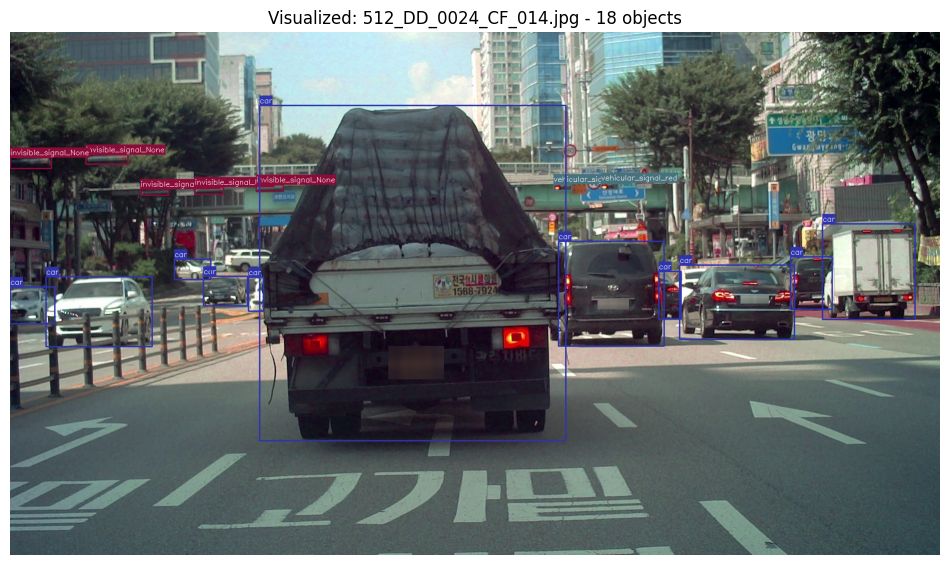

In [ ]:
# Pseudo-Labeling 결과 확인해보기
import cv2
import matplotlib.pyplot as plt
import os

# 1. 파일 경로 설정
image_path = "/content/data/images/512_DD_0024_CF_014.jpg"
label_path = "/content/data/pseudo_labels/512_DD_0024_CF_014.txt"

# 2. 클래스 이름 정의
class_names = [
    "invisible_signal_None",                   # 0
    "vehicular_signal_red",                    # 1
    "vehicular_signal_yellow",                 # 2
    "vehicular_signal_green",                  # 3
    "vehicular_signal_red_and_green_arrow",    # 4
    "vehicular_signal_green_and_green_arrow",  # 5
    "pedestrian_signal_green",                 # 6
    "pedestrian_signal_red",                   # 7
    "pedestrian",                              # 8
    "car"                                      # 9
]

# 클래스별 색상 랜덤 생성 (시각적 구분을 위해)
import random
random.seed(42)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(class_names))]

def visualize_yolo(img_path, txt_path, classes):
    # 이미지 읽기
    if not os.path.exists(img_path) or not os.path.exists(txt_path):
        print("파일을 찾을 수 없습니다.")
        return

    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # 라벨 파일 읽기
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    print(f"이미지 크기: {img_w}x{img_h}")
    print(f"감지된 객체 수: {len(lines)}")

    for line in lines:
        parts = line.strip().split()

        # 데이터가 비어있거나 형식이 이상하면 건너뛰기
        if len(parts) < 5:
            continue

        # 앞의 5개 값만 추출 (뒤에 더미 데이터가 있어도 무시)
        cls_id = int(parts[0])
        cx = float(parts[1])
        cy = float(parts[2])
        w = float(parts[3])
        h = float(parts[4])

        # 정규화된 좌표(0~1)를 픽셀 좌표로 변환
        box_w = int(w * img_w)
        box_h = int(h * img_h)
        box_x = int((cx * img_w) - (box_w / 2))
        box_y = int((cy * img_h) - (box_h / 2))

        # 좌표가 이미지 밖으로 나가지 않게 클리핑 (옵션)
        box_x = max(0, box_x)
        box_y = max(0, box_y)

        # 박스 그리기
        color = colors[cls_id] if cls_id < len(colors) else (255, 255, 255)
        cv2.rectangle(img, (box_x, box_y), (box_x + box_w, box_y + box_h), color, 2)

        # 텍스트 라벨 넣기
        label_text = class_names[cls_id] if cls_id < len(classes) else f"ID {cls_id}"

        # 텍스트 배경 박스 (가독성을 위해)
        (t_w, t_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (box_x, box_y - 20), (box_x + t_w, box_y), color, -1)
        cv2.putText(img, label_text, (box_x, box_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # OpenCV는 BGR을 쓰므로 Matplotlib 출력을 위해 RGB로 변환
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 이미지 출력
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Visualized: {os.path.basename(img_path)} - {len(lines)} objects")
    plt.show()

# 실행
visualize_yolo(image_path, label_path, class_names)

In [ ]:
# 여러 이미지 시각화
import cv2
import matplotlib.pyplot as plt
import os
import random
import glob

# ---------------------------------------------------------
# 1. 설정 및 클래스 정의
# ---------------------------------------------------------
image_dir = "/content/data/images"
label_dir = "/content/data/pseudo_labels"

class_names = [
    "invisible_signal_None",                   # 0
    "vehicular_signal_red",                    # 1
    "vehicular_signal_yellow",                 # 2
    "vehicular_signal_green",                  # 3
    "vehicular_signal_red_and_green_arrow",    # 4
    "vehicular_signal_green_and_green_arrow",  # 5
    "pedestrian_signal_green",                 # 6
    "pedestrian_signal_red",                   # 7
    "pedestrian",                              # 8
    "car"                                      # 9
]

# 클래스별 고정 색상 생성 (랜덤 시드 고정)
random.seed(42)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(class_names))]

# ---------------------------------------------------------
# 2. 이미지-라벨 매칭 및 랜덤 샘플링 함수
# ---------------------------------------------------------
def get_random_samples(img_dir, lbl_dir, num_samples=9):
    # 이미지 파일 확장자 목록
    valid_exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []

    for ext in valid_exts:
        image_files.extend(glob.glob(os.path.join(img_dir, ext)))

    valid_pairs = []

    for img_path in image_files:
        filename = os.path.basename(img_path)
        name_only = os.path.splitext(filename)[0]

        # 대응되는 라벨 파일 경로 생성
        txt_path = os.path.join(lbl_dir, name_only + ".txt")

        # 라벨 파일이 존재하는 경우에만 리스트에 추가
        if os.path.exists(txt_path):
            valid_pairs.append((img_path, txt_path))

    # 샘플링 (파일이 9개보다 적으면 전체 선택)
    if not valid_pairs:
        print("매칭되는 이미지-라벨 쌍을 찾을 수 없습니다.")
        return []

    return random.sample(valid_pairs, min(num_samples, len(valid_pairs)))

# ---------------------------------------------------------
# 3. 단일 이미지에 박스 그리는 함수
# ---------------------------------------------------------
def draw_boxes(img, txt_path, classes, colors):
    img_h, img_w = img.shape[:2]

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    obj_count = 0
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue

        cls_id = int(parts[0])
        cx, cy, w, h = map(float, parts[1:5])

        # 좌표 변환 (Normalized -> Pixel)
        box_w = int(w * img_w)
        box_h = int(h * img_h)
        box_x = int((cx * img_w) - (box_w / 2))
        box_y = int((cy * img_h) - (box_h / 2))

        # 클리핑
        box_x = max(0, box_x)
        box_y = max(0, box_y)

        # 그리기
        color = colors[cls_id] if cls_id < len(colors) else (255, 255, 255)
        cv2.rectangle(img, (box_x, box_y), (box_x + box_w, box_y + box_h), color, 2)

        # 텍스트
        label_text = classes[cls_id] if cls_id < len(classes) else f"ID {cls_id}"

        # 텍스트 배경 및 글자
        (t_w, t_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        # 박스가 위쪽 끝에 붙어있으면 텍스트를 박스 안쪽으로 이동
        text_y_pos = box_y - 5 if box_y - 20 > 0 else box_y + 15

        cv2.rectangle(img, (box_x, box_y - 20 if box_y - 20 > 0 else box_y),
                      (box_x + t_w, box_y if box_y - 20 > 0 else box_y + 20), color, -1)
        cv2.putText(img, label_text, (box_x, text_y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        obj_count += 1

    return img, obj_count

# ---------------------------------------------------------
# 4. 메인 실행 및 3x3 시각화
# ---------------------------------------------------------
samples = get_random_samples(image_dir, label_dir, num_samples=9)

if samples:
    # 3x3 플롯 생성 (크기 조절 가능)
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten() # 1차원 배열로 변환하여 인덱싱 편하게 함

    for i, ax in enumerate(axes):
        if i < len(samples):
            img_path, txt_path = samples[i]

            # 이미지 로드
            img = cv2.imread(img_path)
            if img is None:
                ax.text(0.5, 0.5, 'Image Load Error', ha='center', va='center')
                continue

            # 박스 그리기
            img_drawn, count = draw_boxes(img, txt_path, class_names, colors)

            # BGR -> RGB 변환
            img_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)

            # 서브플롯에 출력
            ax.imshow(img_rgb)
            ax.set_title(f"{os.path.basename(img_path)}\n({count} objects)", fontsize=10)
            ax.axis('off')
        else:
            # 샘플이 9개보다 적을 경우 빈 공간 숨김
            ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("시각화할 데이터가 충분하지 않습니다.")

Output hidden; open in https://colab.research.google.com to view.

# Crosswalk, stop_line 클래스에 대한 Pseudo-labeling

폴더 설명 :

./data/images/         : 원본 이미지

./data/labels/         : 원본 데이터셋 라벨 - json 형식

./data/lidar/          : 원본 라이다 데이터 - pcd 형식

./data/yolo_labels/    : yolo 형식 라벨 (8개 클래스) - txt 형식

./data/pseudo_labels/  : 기존 신호등 8개 클래스 + car, pedestrian 클래스 추가됨 - txt 형식

./data/pseudo_labels_v2/  : 기존 10개 클래스 + crosswalk, stop_line 클래스 추가됨 - txt 형식


In [ ]:
import os
os.makedirs('/content/data/pseudo_labels_v2', exist_ok=True)

# 이미지 개수 확인
print(f'images : {len(os.listdir('/content/data/images'))}')
print(f'json labels : {len(os.listdir('/content/data/labels'))}')
print(f'yolo_labels : {len(os.listdir('/content/data/yolo_labels'))}')
print(f'pseudo_label : {len(os.listdir('/content/data/pseudo_labels'))}')
print(f'pseudo_label_v2 : {len(os.listdir('/content/data/pseudo_labels_v2'))}')

images : 9895
json labels : 9895
yolo_labels : 9895
pseudo_label : 9895
pseudo_label_v2 : 0


In [ ]:
## 우리 모델을 이용해서 Crosswalk, Stop line 클래스에 대한 Pseudo-labeling
# from ultralytics import YOLO
import os
import glob
from tqdm import tqdm

# --- 설정 ---

image_folder = "/content/data/images"
original_label_folder = "/content/data/pseudo_labels"
output_label_folder = "/content/data/pseudo_labels_v2"

print(f"@@ 전체 데이터셋에 대한 Pseudo-labeling을 수행합니다")

# 사용할 사전 학습 모델
model = YOLO('/content/stopline_detection_final.pt')

# 클래스 ID 매핑
NEW_STOP_LINE = 10
NEW_CROSSWALK = 11

os.makedirs(output_label_folder, exist_ok=True)

# jpg + png 같이 있을 수도 있어서 둘 다 잡음(원하면 jpg만 두면 됨)
image_files = sorted(
    glob.glob(os.path.join(image_folder, "*.jpg")) +
    glob.glob(os.path.join(image_folder, "*.png")) +
    glob.glob(os.path.join(image_folder, "*.jpeg"))
)


print(f"@@ 총 {len(image_files)}개의 이미지에 대해 Pseudo-Labeling을 시작합니다")


for img_path in tqdm(image_files):
    file_name = os.path.basename(img_path)
    txt_name = os.path.splitext(file_name)[0] + ".txt"

    original_txt_path = os.path.join(original_label_folder, txt_name)
    save_txt_path = os.path.join(output_label_folder, txt_name)

    # 1. 기존 라벨 읽기
    existing_labels = []
    if os.path.exists(original_txt_path):
        with open(original_txt_path, 'r') as f:
            existing_labels = f.readlines()

    # 2. YOLO로 정지선/횡단보도 추론 (Confidence Threshold 0.4 이상만)
    results = model(img_path, conf=0.4, verbose=False)

    new_labels = []

    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0])

            # 좌표 정규화 (x_center, y_center, w, h)
            # xywhn: normalized xywh
            x, y, w, h = box.xywhn[0].tolist()

            # ID 변환
            if cls_id == 0:                    # stopline
                final_id = NEW_STOP_LINE
            elif cls_id == 1:                  # crosswalk
                final_id = NEW_CROSSWALK

            # 라벨 포맷 생성
            line = f"{final_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n"
            new_labels.append(line)

    # 3. 기존 라벨 + 새 라벨 합치기 & 저장
    final_content = existing_labels + ['\n'] + new_labels

    with open(save_txt_path, 'w') as f:
        f.writelines(final_content)

print(f"@@@ Pseudo-labeling을 완료했습니다")


@@ 전체 데이터셋에 대한 Pseudo-labeling을 수행합니다
@@ 총 9895개의 이미지에 대해 Pseudo-Labeling을 시작합니다


100%|██████████| 9895/9895 [05:27<00:00, 30.18it/s]

@@@ Pseudo-labeling을 완료했습니다


In [ ]:
# 이미지 개수 확인
print(f'images : {len(os.listdir('/content/data/images'))}')
print(f'json labels : {len(os.listdir('/content/data/labels'))}')
print(f'yolo_labels : {len(os.listdir('/content/data/yolo_labels'))}')
print(f'pseudo_label : {len(os.listdir('/content/data/pseudo_labels'))}')
print(f'pseudo_label_v2 : {len(os.listdir('/content/data/pseudo_labels_v2'))}')

images : 9895
json labels : 9895
yolo_labels : 9895
pseudo_label : 9895
pseudo_label_v2 : 9895


=== Random Selection ===
이미지 파일: 512_HD_1117_CF_035.jpg
└── 이미지 크기: 1920x1080
└── 감지된 객체 수: 3


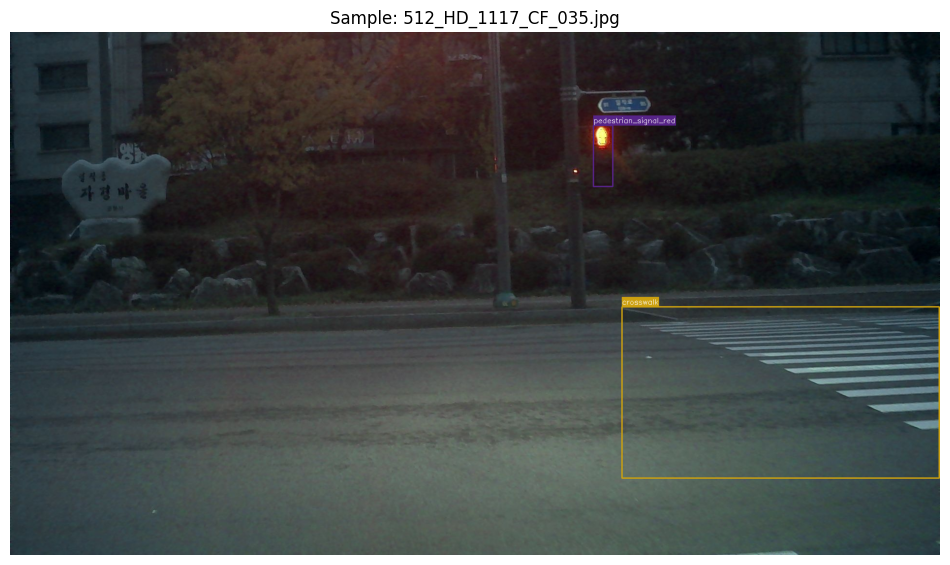

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# ==========================================
# 1. 설정: 데이터셋 폴더 경로 (여기를 수정하세요)
# ==========================================
base_dir = "/content/data"  # 기본 경로
image_dir = os.path.join(base_dir, "images")        # 이미지 폴더
label_dir = os.path.join(base_dir, "pseudo_labels_v2") # 라벨 폴더

# ==========================================
# 2. 클래스 이름 정의
# ==========================================
class_names = [
    "invisible_signal_None",                   # 0
    "vehicular_signal_red",                    # 1
    "vehicular_signal_yellow",                 # 2
    "vehicular_signal_green",                  # 3
    "vehicular_signal_red_and_green_arrow",    # 4
    "vehicular_signal_green_and_green_arrow",  # 5
    "pedestrian_signal_green",                 # 6
    "pedestrian_signal_red",                   # 7
    "pedestrian",                              # 8
    "car",                                     # 9
    "stopline",                                # 10
    "crosswalk"                                # 11
]

# 클래스별 색상 랜덤 생성
#random.seed(42)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(class_names))]

# ==========================================
# 3. 시각화 함수 (기존 로직 유지 + 버그 방지)
# ==========================================
def visualize_yolo(img_path, txt_path, classes):
    # 파일 존재 여부 확인
    if not os.path.exists(img_path):
        print(f"[Error] 이미지를 찾을 수 없습니다: {img_path}")
        return
    if not os.path.exists(txt_path):
        print(f"[Warning] 라벨 파일이 없습니다 (빈 이미지로 표시됩니다): {txt_path}")
        lines = [] # 라벨이 없으면 빈 리스트 처리
    else:
        with open(txt_path, 'r') as f:
            lines = f.readlines()

    img = cv2.imread(img_path)
    if img is None:
        print(f"[Error] 이미지를 읽을 수 없습니다.")
        return

    img_h, img_w = img.shape[:2]

    print(f"└── 이미지 크기: {img_w}x{img_h}")
    print(f"└── 감지된 객체 수: {len(lines)}")

    for line in lines:
        parts = line.strip().split()

        if len(parts) < 5: continue

        cls_id = int(parts[0])
        cx, cy, w, h = map(float, parts[1:5])

        # 좌표 변환
        box_w = int(w * img_w)
        box_h = int(h * img_h)
        box_x = int((cx * img_w) - (box_w / 2))
        box_y = int((cy * img_h) - (box_h / 2))

        # 그리기
        color = colors[cls_id] if cls_id < len(colors) else (255, 255, 255)

        # 박스
        cv2.rectangle(img, (box_x, box_y), (box_x + box_w, box_y + box_h), color, 2)

        # 라벨 텍스트
        label_text = class_names[cls_id] if cls_id < len(classes) else f"ID {cls_id}"

        # 텍스트 배경 및 글자
        (t_w, t_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        # 박스가 위쪽 끝에 붙어있으면 텍스트를 박스 안쪽으로 이동
        if box_y - 20 < 0:
            text_bg_y1, text_bg_y2 = box_y, box_y + 20
            text_y = box_y + 15
        else:
            text_bg_y1, text_bg_y2 = box_y - 20, box_y
            text_y = box_y - 5

        cv2.rectangle(img, (box_x, text_bg_y1), (box_x + t_w, text_bg_y2), color, -1)
        cv2.putText(img, label_text, (box_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # 출력
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Sample: {os.path.basename(img_path)}")
    plt.show()

# ==========================================
# 4. 랜덤 샘플링 실행 함수
# ==========================================
def visualize_random_sample(img_dir, lbl_dir, classes):
    # 이미지 폴더에서 파일 목록 가져오기 (확장자 필터링)
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
    try:
        image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(valid_exts)]
    except FileNotFoundError:
        print(f"[Error] 이미지 폴더 경로가 잘못되었습니다: {img_dir}")
        return

    if not image_files:
        print("[Error] 폴더 내에 이미지 파일이 없습니다.")
        return

    # 랜덤 선택
    selected_file = random.choice(image_files)

    # 경로 구성
    img_path = os.path.join(img_dir, selected_file)

    # 라벨 파일명 유추 (이미지 확장자를 .txt로 변경)
    file_name_no_ext = os.path.splitext(selected_file)[0]
    lbl_path = os.path.join(lbl_dir, file_name_no_ext + ".txt")

    print(f"=== Random Selection ===")
    print(f"이미지 파일: {selected_file}")

    # 시각화 실행
    visualize_yolo(img_path, lbl_path, classes)

# ==========================================
# 실행
# ==========================================
# 여러 번 실행하면 계속 다른 이미지가 나옵니다.
visualize_random_sample(image_dir, label_dir, class_names)

# Data Split

train : val : test = 8 : 1 : 1 으로 나누기

In [ ]:
import os
import glob
import shutil
import random
from pathlib import Path

# --- 설정값 ---
# 기존 데이터 경로
src_img_path = "/content/data/images"
src_label_path = "/content/data/pseudo_labels_v2"

# 데이터가 이동될 최종 경로 (YOLO 학습에 이용 예정)
dest_root = "/content/datasets"

# 분할 비율 (Train : Val : Test) = 8 : 1 : 1
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# 랜덤 시드 설정
random_seed = 42

# ---------------------------------------------

def split_dataset():
    # 1. 파일 리스트 확보 (라벨 파일 기준)
    # 이미지 확장자는 jpg라고 가정하지만, 필요시 수정 가능
    label_files = glob.glob(os.path.join(src_label_path, "*.txt"))

    # 짝이 맞는 데이터만 찾기 위해 파일명(stem) 추출
    # 예: "img_01.txt" -> "img_01"
    data_pairs = []

    print(f"원본 라벨 파일 검색 중... 총 {len(label_files)}개 발견")

    for label_file in label_files:
        basename = os.path.splitext(os.path.basename(label_file))[0]

        # 대응되는 이미지 파일 찾기 (jpg, png 등 확인)
        # 우선순위: jpg -> png -> jpeg
        image_file = os.path.join(src_img_path, f"{basename}.jpg")

        if not os.path.exists(image_file):
            # 혹시 jpg가 아니라면 다른 확장자 체크
            for ext in ['.png', '.jpeg', '.JPG']:
                temp_path = os.path.join(src_img_path, f"{basename}{ext}")
                if os.path.exists(temp_path):
                    image_file = temp_path
                    break

        if os.path.exists(image_file):
            data_pairs.append((image_file, label_file))
        else:
            print(f"[경고] 이미지 파일을 찾을 수 없음: {basename}")

    total_count = len(data_pairs)
    print(f"유효한 이미지-라벨 쌍: {total_count}개")

    # 2. 데이터 섞기 (Shuffle)
    random.seed(random_seed)
    random.shuffle(data_pairs)

    # 3. 분할 인덱스 계산
    train_end = int(total_count * train_ratio)
    val_end = train_end + int(total_count * val_ratio)

    train_set = data_pairs[:train_end]
    val_set = data_pairs[train_end:val_end]
    test_set = data_pairs[val_end:]

    print(f"\n[분할 결과]")
    print(f"- Train: {len(train_set)}개")
    print(f"- Val  : {len(val_set)}개")
    print(f"- Test : {len(test_set)}개")

    # 4. 폴더 생성 및 파일 이동 함수
    def move_files(file_list, split_name):
        # 목표 디렉토리 생성
        img_dest = os.path.join(dest_root, "images", split_name)
        lbl_dest = os.path.join(dest_root, "labels", split_name)

        os.makedirs(img_dest, exist_ok=True)
        os.makedirs(lbl_dest, exist_ok=True)

        for img, lbl in file_list:
            # shutil.move: 파일 이동 (원본 삭제됨)
            # 원본 보존을 원하면 shutil.copy로 변경하세요
            shutil.move(img, os.path.join(img_dest, os.path.basename(img)))
            shutil.move(lbl, os.path.join(lbl_dest, os.path.basename(lbl)))

    # 5. 실제 이동 실행
    print("\n파일 이동을 시작합니다...")
    move_files(train_set, "train")
    move_files(val_set, "val")
    move_files(test_set, "test")

    print("모든 작업이 완료되었습니다! '/content/datasets/' 경로를 확인하세요.")

# 실행
split_dataset()

원본 라벨 파일 검색 중... 총 9895개 발견
유효한 이미지-라벨 쌍: 9895개

[분할 결과]
- Train: 7916개
- Val  : 989개
- Test : 990개

파일 이동을 시작합니다...
모든 작업이 완료되었습니다! '/content/datasets/' 경로를 확인하세요.


# Pseudo-labeling이 완료된 데이터셋을 기반으로 학습 진행


In [ ]:
import yaml

# YAML에 들어갈 내용 설정
yaml_data = {
    'path': '/content/datasets', # 데이터셋 루트 경로
    'train': 'images/train',      # 학습 이미지 경로
    'val': 'images/val',        # 검증 이미지 경로
    'test': 'images/test',       # 테스트 이미지 경로

    'nc': 12,                   # 클래스 개수
    'names': [
        'invisible_signal_None',
        'vehicular_signal_red',
        'vehicular_signal_yellow',
        'vehicular_signal_green',
        'vehicular_signal_red_and_green_arrow',
        'vehicular_signal_green_and_green_arrow',
        'pedestrian_signal_green',
        'pedestrian_signal_red',
        'pedestrian',
        'car',
        'stopline',
        'crosswalk'
        ] # 클래스 이름 (인덱스 순서대로)
}

# yaml 파일 저장
yaml_path = '/content/datasets/data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"✅ {yaml_path} 생성이 완료되었습니다!")

# 생성된 내용 확인
with open(yaml_path, 'r') as f:
    print("\n--- data.yaml 내용 ---")
    print(f.read())

✅ /content/datasets/data.yaml 생성이 완료되었습니다!

--- data.yaml 내용 ---
names:
- invisible_signal_None
- vehicular_signal_red
- vehicular_signal_yellow
- vehicular_signal_green
- vehicular_signal_red_and_green_arrow
- vehicular_signal_green_and_green_arrow
- pedestrian_signal_green
- pedestrian_signal_red
- pedestrian
- car
- stopline
- crosswalk
nc: 12
path: /content/datasets
test: images/test
train: images/train
val: images/val



In [ ]:
import torch
import gc

def clear_gpu_memory():
    # 1. 가비지 컬렉터 실행 (참조되지 않는 파이썬 객체 제거)
    gc.collect()

    # 2. CUDA 캐시 비우기 (PyTorch가 잡고 있는 미사용 GPU 메모리 해제)
    torch.cuda.empty_cache()

    print("GPU 메모리 정리가 완료되었습니다.")

# 사용법:
# 만약 특정 모델이나 큰 변수를 지우고 싶다면 먼저 del을 수행하세요.
# del model
# del inputs
clear_gpu_memory()

GPU 메모리 정리가 완료되었습니다.


In [7]:
import torch
import cv2
import numpy as np
import yaml

print(torch.__version__)
print(cv2.__version__)
print(np.__version__)
print(yaml.__version__)

2.9.0+cu128
4.13.0
2.0.2
6.0.3


In [ ]:
from ultralytics import YOLO
import random
import torch
import numpy as np

%cd /content/

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 1. 모델 불러오기
model_name = "yolo26s.pt"

max_epochs = 50
imgsize    = 960
batch_size = 64
exp_num = 'exp6'

model = YOLO(model_name)

save_dir = f"integrated_det_{exp_num}_{model_name.split('.')[0]}_e{max_epochs}_b{batch_size}_imgsz{imgsize}"

# 모델 학습
train_results = model.train(
    data = "/content/datasets/data.yaml",
    epochs = max_epochs,
    imgsz = imgsize,
    batch = batch_size,
    device = 0,     # Device to run on (e.g., 'cpu', 0, [0,1,2,3])
    name = save_dir,
    val =True,
    plots = True,

    cls = 1.5,     # classification loss weights,       default = 0.5
    box = 6.5,     # bounding box loss weights,         default = 7.5
    dfl = 2.5      # distributional focal loss weights, default = 1.5

    # color augmentation 가중치 조정
    # hsv_h=0.005,  # hue 값을 조정, default = 0.015
    # hsv_s=0.5     # saturation 값을 조정, default = 0.7
)



/content
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=6.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=2.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=integrated_det_exp6_yolo26m_e50_b64_imgsz960, nbs=64, nms=False, opset=None, optimize=False, optim

In [ ]:
# 구글드라이브에 학습 결과 저장

from google.colab import drive
import os
import datetime
import subprocess

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# ==========================================
# 설정
# ==========================================

dd = datetime.datetime.now().strftime("%y%m%d")
source_folder = f'/content/runs/detect/{save_dir}'                 # 복사할 원본 폴더
dest_folder = f'/content/drive/MyDrive/integrated_det_{dd}'
config_folder = os.path.join(dest_folder, save_dir)

# ==========================================
# 실행 로직
# ==========================================
# 저장할 폴더 생성
os.makedirs(dest_folder, exist_ok=True)
os.makedirs(config_folder, exist_ok=True)

print(f"📂 '{source_folder}'의 내용을\n '{config_folder}'로 복사합니다...")

# rsync 명령어 실행 (-a: 아카이브 모드, -v: 상세출력, --progress: 진행률)
# 폴더 통째로 복사
command = f"rsync -av --progress '{source_folder}/' '{config_folder}'"

# 쉘 명령어 실행
subprocess.call(command, shell=True)

print("\n✅ 복사 작업이 완료되었습니다!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 '/content/runs/detect/integrated_det_exp6_yolo26m_e50_b64_imgsz960'의 내용을
 '/content/drive/MyDrive/integrated_det_260210/integrated_det_exp6_yolo26m_e50_b64_imgsz960'로 복사합니다...

✅ 복사 작업이 완료되었습니다!


In [ ]:
# 테스트 셋에서 모델 성능 측정

from ultralytics import YOLO

# 1. 모델 로드 및 검증 수행
model = YOLO(f'/content/runs/detect/{save_dir}/weights/best.pt')  # 경로 확인 필요
metrics = model.val(data='/content/datasets/data.yaml', split='test')

# 2. 전체적인 성능 지표 출력
print(f"mAP50-95: {metrics.box.map}")    # 전반적인 성능 (IoU 0.5~0.95 평균)
print(f"mAP50: {metrics.box.map50}")      # IoU 0.5 기준 성능 (일반적으로 많이 보는 지표)
print(f"mAP75: {metrics.box.map75}")      # IoU 0.75 기준 (더 엄격한 기준)

# 3. 클래스별 성능 확인 (신호등 종류가 여러 개인 경우 유용)
# metrics.box.maps는 각 클래스별 mAP50-95 값을 배열로 가지고 있습니다.
print(f"Class indices: {metrics.box.maps}")

Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO26m summary (fused): 132 layers, 20,358,704 parameters, 0 gradients, 67.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2606.1±367.0 MB/s, size: 335.6 KB)
val: Scanning /content/datasets/labels/test... 990 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 990/990 1.5Kit/s 0.7s
val: /content/datasets/images/test/512_DD_0046_CF_007.jpg: 1 duplicate labels removed
val: /content/datasets/images/test/512_DD_0057_CF_010.jpg: 1 duplicate labels removed
val: /content/datasets/images/test/512_DD_0755_CF_018.jpg: 1 duplicate labels removed
val: /content/datasets/images/test/512_DN_1410_CF_011.jpg: 1 duplicate labels removed
val: /content/datasets/images/test/512_HD_0775_CF_016.jpg: 1 duplicate labels removed
val: /content/datasets/images/test/512_ND_0231_CF_043.jpg: 1 duplicate labels removed
val: /content/datasets/images/test/512_NN_1178_CF_005.jpg: 1 duplicate labels removed
val: /co

# 동영상에서 돌리기

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/runs/detect/integrated_det_exp6_yolo26m_e50_b64_imgsz960/weights/best.pt')
results = model.predict(source='/content/test_video_260130.mp4', save=True, show=True)


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/405) /content/test_video_260130.mp4: 608x960 4 vehicular_signal_greens, 1 pedestrian, 10 cars, 103.7ms
video 1/1 (frame 2/405) /content/test_video_260130.mp4: 608x960 4 vehicular_signal_greens, 2 pedestrians, 10 cars, 14.6ms
video 1/1 (frame 3/405) /content/test_video_260130.mp4: 608x960 4 vehicular_signal_greens, 1 pedestrian, 11 cars, 13.8ms
video 1/1 (frame 4/405) /content/test_video_260130.mp4: 608x960 4 vehicular_signal_greens, 2 